In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import anndata
from anndata import read_h5ad
import warnings
import umap
warnings.filterwarnings("ignore")
import torch
import math
import random
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class simdatset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = torch.from_numpy(self.X[index]).float().to(device)
        y = torch.from_numpy(self.Y[index]).float().to(device)
        return x, y

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.name = 'ae'
        self.inputdim = input_dim
        self.outputdim = output_dim
        self.encoder = nn.Sequential(nn.Dropout(),
                                     nn.Linear(self.inputdim,512),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(512,256),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(256,128),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(128,64),
                                     nn.CELU(),
                                     nn.Linear(64,output_dim),
                                     )
        
        self.decoder = nn.Sequential(nn.Linear(self.outputdim,64,bias=False),
                                     nn.Linear(64,128,bias=False),
                                     nn.Linear(128,256,bias=False),
                                     nn.Linear(256,512,bias=False),
                                     nn.Linear(512,self.inputdim,bias=False))
        
                                               
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,z):
        return self.decoder(z)

    def sigmatrix(self):
        w0 = self.decoder[0].weight.T
        w1 = self.decoder[1].weight.T
        w2 = self.decoder[2].weight.T
        w3 = self.decoder[3].weight.T
        w4 = self.decoder[4].weight.T
        w01 = torch.mm(w0,w1)
        w02 = torch.mm(w01,w2)
        w03 = torch.mm(w02,w3)
        w04 = torch.mm(w03, w4)
        return torch.abs(w04)

    def forward(self, x):
        sigmatrix = self.sigmatrix()
        z = self.encode(x)
        x_recon = torch.mm(z,sigmatrix)
        return x_recon, z, sigmatrix


def train(model, train_loader, optimizer, epochs=10):
    model.train()
    loss = []
    recon_loss = []

    for i in tqdm(range(epochs)):
        for k, (data, label) in enumerate(train_loader):
            optimizer.zero_grad()
            x_recon, cell_prop, _ = model(data)
            batch_loss = F.l1_loss(cell_prop, label)+F.l1_loss(x_recon,data)
            batch_loss.backward()
            optimizer.step()
            loss.append(F.l1_loss(cell_prop, label).cpu().detach().numpy())
            recon_loss.append(F.l1_loss(x_recon, data).cpu().detach().numpy())

    return model, loss, recon_loss



def predict(model, data):
    model.eval()
    data = torch.from_numpy(data).float().to(device)
    _, pred, sigmatrix = model(data)
    pred = pred.cpu().detach().numpy()
    sigmatrix = sigmatrix.cpu().detach().numpy()
    return pred, sigmatrix


def adaptive_sigm(model, data, optimizerD, optimizerE, max_iter=5):
    data = torch.from_numpy(data).float().to(device)
    loss = []
    model.eval()
    ori_pred = model.encode(data).detach()
    
    for k in tqdm(range(max_iter)):
        model.eval()
        for i in range(1000):
        
            optimizerD.zero_grad()
            x_recon, _, _ = model(data)
            batch_loss = F.l1_loss(x_recon, data)
            batch_loss.backward()
            optimizerD.step()
            loss.append(batch_loss.cpu().detach().numpy())
    
        
        for i in range(1000):
        
            optimizerE.zero_grad()
            x_recon, pred, _ = model(data)
            batch_loss = F.l1_loss(x_recon, data)+F.l1_loss(ori_pred,pred)
            batch_loss.backward()
            optimizerE.step()
            loss.append(batch_loss.cpu().detach().numpy())

        
    model.eval()
    pred = model.encode(data)
    sigm = model.sigmatrix()
    
    return sigm.cpu().detach().numpy(), loss

def RMSEscore(pred, true):
    return np.mean(np.abs(pred - true))


def CCCscore(y_pred, y_true):
    # pred: shape{n sample, m cell}
    ccc_value = 0
    for i in range(y_pred.shape[1]):
        r = np.corrcoef(y_pred[:, i], y_true[:, i])[0, 1]
        # print(r)
        # Mean
        mean_true = np.mean(y_true[:, i])
        mean_pred = np.mean(y_pred[:, i])
        # Variance
        var_true = np.var(y_true[:, i])
        var_pred = np.var(y_pred[:, i])
        # Standard deviation
        sd_true = np.std(y_true[:, i])
        sd_pred = np.std(y_pred[:, i])
        # Calculate CCC
        numerator = 2 * r * sd_true * sd_pred
        denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
        ccc = numerator / denominator
        # print(ccc)
        ccc_value += ccc
    return ccc_value / y_pred.shape[1]

def score(pred, label):
    distance = []
    ccc = []
    new_pred = pred.reshape(-1,1)
    new_label = label.reshape(-1,1)
    distance.append(RMSEscore(new_pred, new_label))
    ccc.append(CCCscore(new_pred, new_label))
    print(distance[0], ccc[0])
    return distance[0], ccc[0]

def showloss(loss):
    plt.figure()
    plt.plot(loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()
            
def reproducibility(seed=1):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


In [3]:
def preprocess(trainingdatapath, testx, testy):
    # human brain dataset
    trainset = read_h5ad(trainingdatapath)
    testset = pd.read_csv(testx,sep='\t',index_col=0)
    #display(testset)
    testlabel = pd.read_csv(testy,index_col=0)
    #display(testlabel)
    test_y = testlabel.iloc[:,:].values
    test_y = np.array(test_y,dtype=float)
    ### refraction
    for i, values in enumerate(test_y):
        r_sum = np.sum(values)
        if r_sum == 0:
            pass
        else:
            test_y[i] = test_y[i] / r_sum
    ### find intersect genes
    intersection_genes = list(testset.index.intersection(trainset.var.index))
    print(len(intersection_genes))
    test_x = testset.loc[intersection_genes]
    test_x = test_x.T.values
    simuvar = list(trainset.var.index)
    intersection_gene_position = []
    for gene in intersection_genes:
        intersection_gene_position.append(simuvar.index(gene))
    selected = np.zeros((len(intersection_genes), len(trainset.X)))
    for i in range(selected.shape[0]):
        selected[i] = trainset.X.T[intersection_gene_position[i]]
    train_x = selected.T
    
    
    # merge ex&in-neurons
    trainset.obs['Neurons'] = trainset.obs['ExNeurons']+trainset.obs['InNeurons']
    # find intersect cell proportions
    intersection_cell = list(testlabel.columns.intersection(trainset.obs.columns))
    print(intersection_cell)
    train_y = trainset.obs[intersection_cell].values
    ### refraction
    for i, values in enumerate(train_y):
        r_sum = np.sum(values)
        if r_sum == 0:
            pass
        else:
            train_y[i] = train_y[i] / r_sum
    ### variance cutoff
    label = test_x.var(axis=0) > 0.1
    test_x_new = np.zeros((test_x.shape[0],np.sum(label)))
    train_x_new = np.zeros((train_x.shape[0],np.sum(label)))
    k = 0
    selectgenes = []
    for i in range(len(label)):
        if label[i] == True:
            test_x_new[:,k] = test_x[:,i]
            train_x_new[:,k] = train_x[:,i]
            selectgenes.append(intersection_genes[i])
            k += 1
    
    return train_x_new, train_y, test_x_new, test_y, selectgenes, intersection_cell

In [4]:
train_x, train_y, test_x, test_y, genename, celltypes = preprocess(trainingdatapath='../humanbrain/GSE67835.h5ad', 
                                                                   testx='../ROSMAP_lengthScaledTPM_counts.txt', 
                                                                   testy='../ROSMAP_IHC_fractions.csv')
test_y = np.zeros((test_x.shape[0],train_y.shape[1]))
train_x = np.log2(train_x + 1)
test_x = np.log2(test_x + 1)
mms = MinMaxScaler()
test_x = mms.fit_transform(test_x.T)
test_x = test_x.T
train_x = mms.fit_transform(train_x.T)
train_x = train_x.T
print('train_x shape',train_x.shape)
print('train_y shape',train_y.shape)
print('test_x shape',test_x.shape)

12905
['Astrocytes', 'Endothelial', 'Microglia', 'Neurons', 'Oligodendrocytes']
train_x shape (2000, 12185)
train_y shape (2000, 5)
test_x shape (639, 12185)


In [5]:
samplename = list(pd.read_csv('../ROSMAP_lengthScaledTPM_counts.txt',sep='\t',index_col=0).columns)
IDkey = pd.read_csv('../filtered_meta.txt',sep='\t')

In [6]:
testx = pd.DataFrame(test_x,index=samplename)
testx = testx.loc[testx.index.intersection(IDkey['rnaseq_id'])]

In [7]:
rnaseqid = list(IDkey['rnaseq_id'])
braaksc = list(IDkey['braaksc'])
ceradsc = list(IDkey['ceradsc'])
braak = []
cerad = []
intersection = testx.index.intersection(rnaseqid)
for seqid in testx.index:
    index = rnaseqid.index(seqid)
    braak.append(braaksc[index])
    cerad.append(ceradsc[index])
print(len(braak),len(cerad))

532 532


In [8]:
testx['braak'] = braak
testx['cerad'] = cerad

In [9]:
cerad_stage_data = []
for i in range(4):
    cerad_stage_data.append(testx[testx['cerad']==(i+1)].iloc[:,:-2].values)

100%|██████████| 3/3 [00:13<00:00,  4.66s/it]


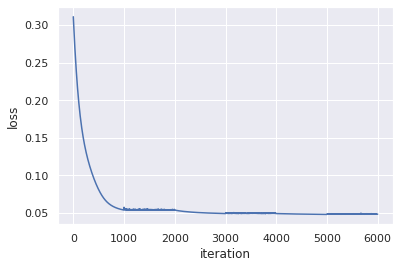

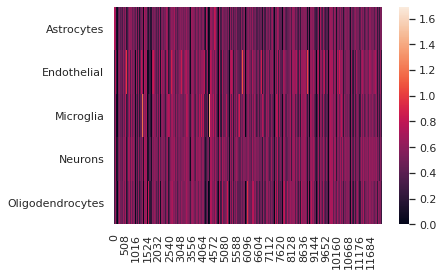

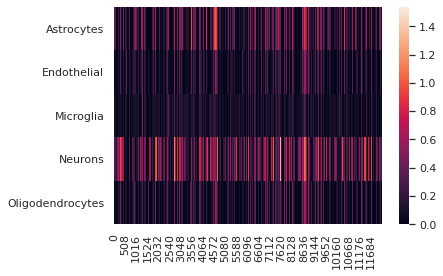

31
8154
CLSTN1
NAP1L2
GLUL
MT3
NAPB
TSPYL1
ALDOA
NEFH
NAP1L3
NRGN


100%|██████████| 3/3 [00:13<00:00,  4.66s/it]


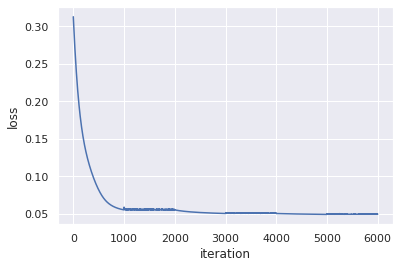

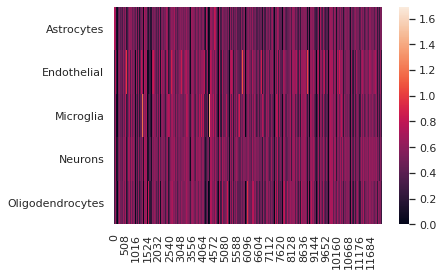

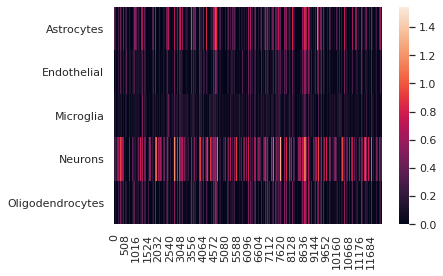

18
8062
NAP1L2
MT3
NAT8L
TSPYL1
NAPB
NEFH
ALDOA
GLUL
NAP1L3
NRGN


100%|██████████| 3/3 [00:13<00:00,  4.56s/it]


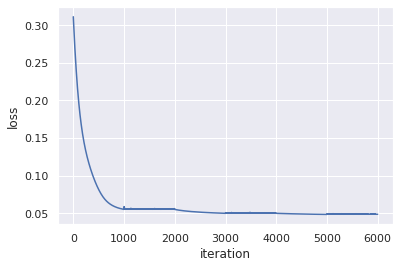

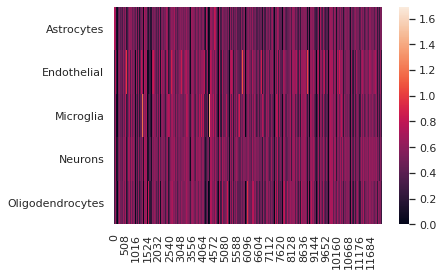

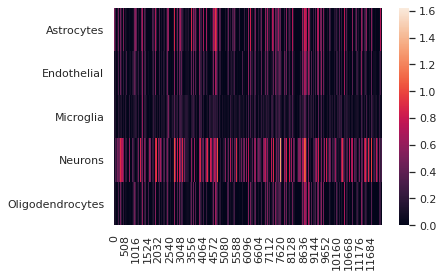

19
11102
NAP1L2
CNRIP1
ALDOA
NEFH
ARPP19
OAT
NAPB
NAP1L3
NRGN
GLUL


100%|██████████| 3/3 [00:13<00:00,  4.63s/it]


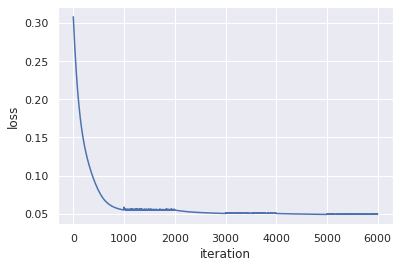

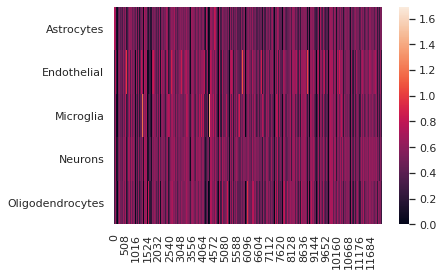

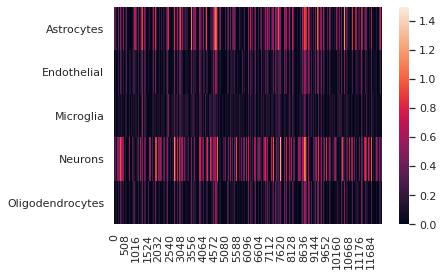

15
8389
GLUL
KCNJ4
MT3
NAT8L
TSPYL1
ALDOA
NAPB
NEFH
NAP1L3
NRGN


In [10]:
sns.set()
for i in range(4):
    reproducibility(seed=0)
    train_loader = data.DataLoader(simdatset(train_x, train_y), batch_size=128, shuffle=True)
    model = AutoEncoder(train_x.shape[1], train_y.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
    model, loss, reconloss = train(model, train_loader, optimizer, epochs=300)
    _, train_sigm = predict(model, test_x)
    decoder_parameters = [{'params': [p for n, p in model.named_parameters() if 'decoder' in n]}]
    encoder_parameters = [{'params': [p for n, p in model.named_parameters() if 'encoder' in n]}]
    optimizerD = torch.optim.Adam(decoder_parameters, lr=1e-5)
    optimizerE = torch.optim.Adam(encoder_parameters, lr=1e-5)
    test_sigm, loss = adaptive_sigm(model, cerad_stage_data[i], optimizerD, optimizerE, max_iter=3)
    showloss(loss)
    sns.heatmap(train_sigm, yticklabels=celltypes,vmin=0)
    plt.show()
    sns.heatmap(test_sigm, yticklabels=celltypes,vmin=0)
    plt.show()
    top10 = np.argsort(test_sigm[3,:])[-10:]
    print(len(test_sigm[3,:])-list(np.argsort(test_sigm[3,:])).index([genename.index('SYNPO')]))
    print(len(test_sigm[3,:])-list(np.argsort(test_sigm[3,:])).index([genename.index('BAG3')]))
    for index in top10:
        print(genename[index])

In [11]:
braak_stage_data = []
for i in range(7):
    braak_stage_data.append(testx[testx['braak']==i].iloc[:,:-2].values)

100%|██████████| 3/3 [00:13<00:00,  4.45s/it]


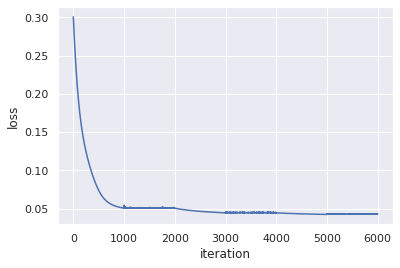

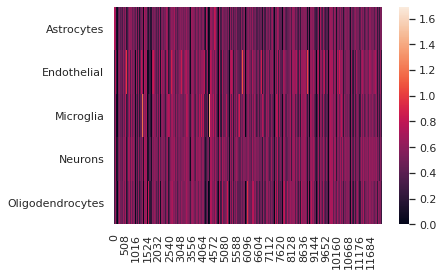

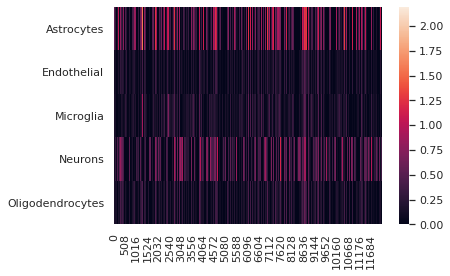

1
7654
KIF5C
EXTL1
LZTS1
LMO4
NEFH
PARM1
NAP1L3
NRGN
NAPB
SYNPO


100%|██████████| 3/3 [00:13<00:00,  4.60s/it]


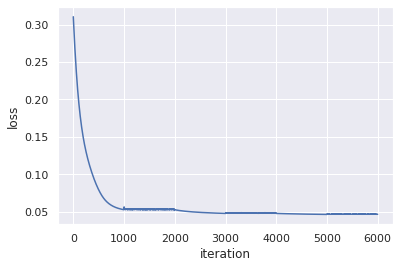

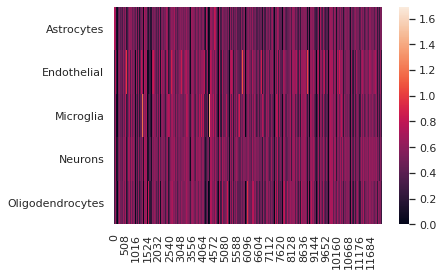

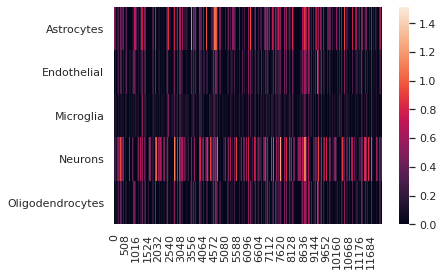

18
12137
ARPP19
OAT
NEFH
NAT8L
MT3
NAPB
ALDOA
NAP1L3
GLUL
NRGN


100%|██████████| 3/3 [00:13<00:00,  4.54s/it]


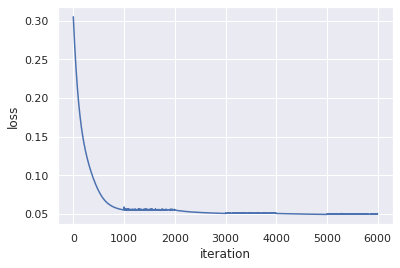

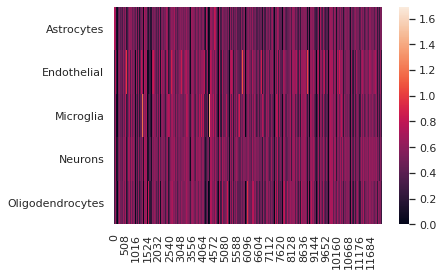

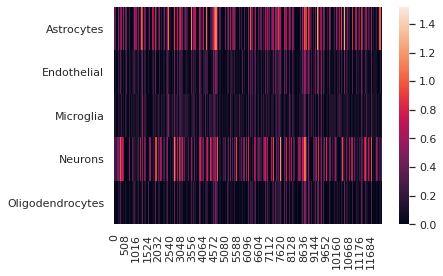

23
7651
LMO4
NEFH
KCNJ4
TSPYL1
ALDOA
NAT8L
KIF5C
NAPB
NAP1L3
NRGN


100%|██████████| 3/3 [00:14<00:00,  4.68s/it]


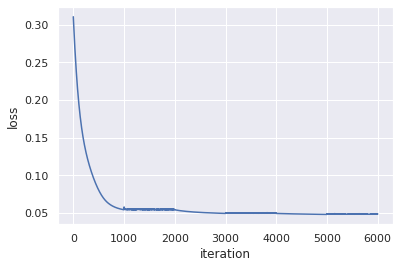

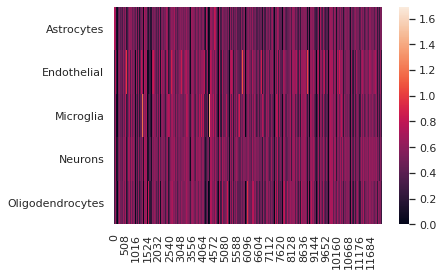

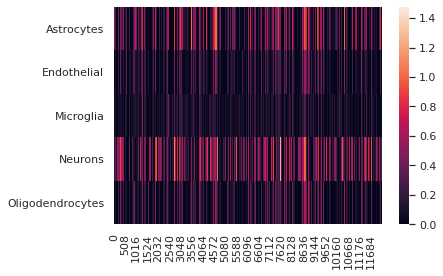

8
8884
TSPYL1
NAP1L2
SYNPO
ALDOA
OAT
NEFH
NAPB
GLUL
NAP1L3
NRGN


100%|██████████| 3/3 [00:13<00:00,  4.67s/it]


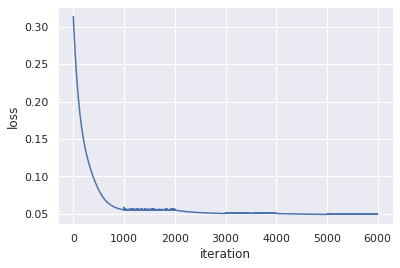

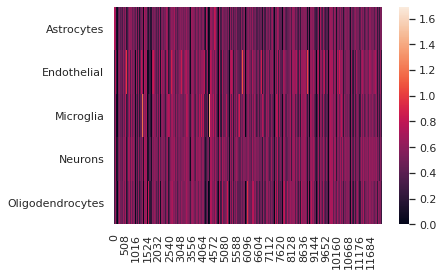

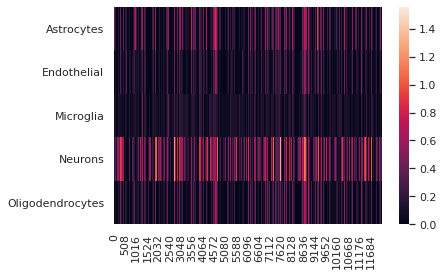

46
8226
CLSTN1
GLUL
NAT8L
KCNJ4
MT3
TSPYL1
ALDOA
NEFH
NAP1L3
NRGN


100%|██████████| 3/3 [00:13<00:00,  4.63s/it]


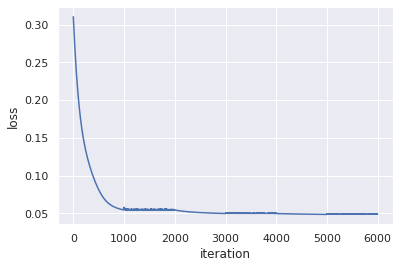

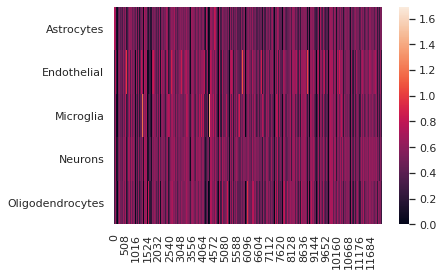

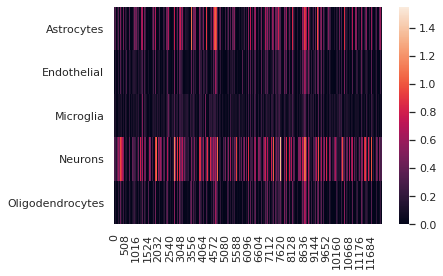

16
7959
NAT8L
KCNJ4
PNMA3
GLUL
TSPYL1
NEFH
NAPB
ALDOA
NAP1L3
NRGN


100%|██████████| 3/3 [00:13<00:00,  4.46s/it]


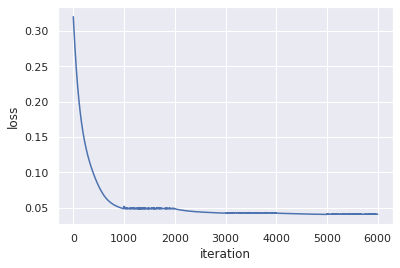

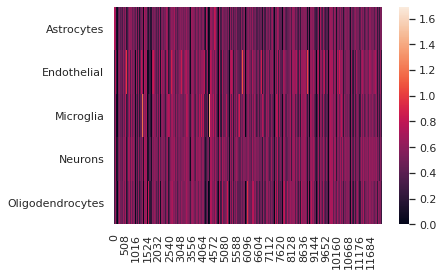

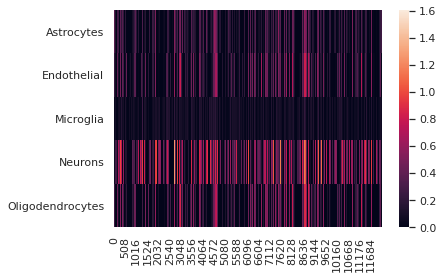

33
6948
NAT8L
NAP1L2
CACNG8
TSPYL1
MRFAP1
MT3
ALDOA
LMO4
NAP1L3
NRGN


In [12]:
for i in range(7):
    reproducibility(seed=0)
    train_loader = data.DataLoader(simdatset(train_x, train_y), batch_size=128, shuffle=True)
    model = AutoEncoder(train_x.shape[1], train_y.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
    model, loss, reconloss = train(model, train_loader, optimizer, epochs=300)
    _, train_sigm = predict(model, test_x)
    decoder_parameters = [{'params': [p for n, p in model.named_parameters() if 'decoder' in n]}]
    encoder_parameters = [{'params': [p for n, p in model.named_parameters() if 'encoder' in n]}]
    optimizerD = torch.optim.Adam(decoder_parameters, lr=1e-5)
    optimizerE = torch.optim.Adam(encoder_parameters, lr=1e-5)
    test_sigm, loss = adaptive_sigm(model, braak_stage_data[i], optimizerD, optimizerE, max_iter=3)
    showloss(loss)
    sns.heatmap(train_sigm, yticklabels=celltypes,vmin=0)
    plt.show()
    sns.heatmap(test_sigm, yticklabels=celltypes,vmin=0)
    plt.show()
    top10 = np.argsort(test_sigm[3,:])[-10:]
    print(len(test_sigm[3,:])-list(np.argsort(test_sigm[3,:])).index([genename.index('SYNPO')]))
    print(len(test_sigm[3,:])-list(np.argsort(test_sigm[3,:])).index([genename.index('BAG3')]))
    for index in top10:
        print(genename[index])

In [13]:
print(len(train_sigm[3,:])-list(np.argsort(train_sigm[3,:])).index([genename.index('SYNPO')]))

8513


In [14]:
print(len(train_sigm[3,:])-list(np.argsort(train_sigm[3,:])).index([genename.index('BAG3')]))

3128
